In [104]:
import pandas as pd
import matplotlib.pyplot as plt 
import pytorch_lightning as pl
from model import *
from module import * 
import altair as alt
from pytorch_lightning.callbacks.progress import TQDMProgressBar
import torch 
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import argparse
import numpy as np
from pytorch_lightning.callbacks import ModelCheckpoint
from  pytorch_lightning.loggers.tensorboard import TensorBoardLogger

Analyze distance prediction error

Analyze error per person

In [2]:
backbone = "resnet"
dataset = "comma"
bs = 1
gpu_num = 2

In [3]:
def mse_loss(input, target, mask, reduction="mean"):
        out = (input[~mask]-target[~mask])**2
        return out.mean() if reduction == "mean" else out 

In [58]:
def calculate_loss(logits, angle, distance, multitask):
        if multitask == "multitask":
            logits_angle, logits_dist = logits
            mask = distance.squeeze() == 0.0
            loss_angle = torch.sqrt(mse_loss(logits_angle.squeeze(), angle.squeeze(), mask))
            loss_distance = torch.sqrt(mse_loss(logits_dist.squeeze(), distance.squeeze(), mask))
            loss = loss_angle, loss_distance
            return loss_angle, loss_distance
        elif multitask == "angle":
            mask = distance.squeeze() == 0.0 
            loss = torch.sqrt(mse_loss(logits.squeeze(), angle.squeeze(), mask))
            return loss
        elif multitask == "distance":
            mask = (distance > 50)  | (distance == 0)
            loss = torch.sqrt(mse_loss(logits.squeeze(), angle.squeeze(), mask))
            return loss

In [67]:
ckpt_pth_angle = f"/data1/jessica/data/toyota/ckpts/COMMA/checkpoints_comma_angle/lightning_logs/version_17/checkpoints/epoch=21-step=1694.ckpt"
ckpt_pth_distance = f"/data1/jessica/data/toyota/ckpts/COMMA/checkpoints_comma_distance/lightning_logs/version_40/checkpoints/epoch=39-step=1960.ckpt"
ckpt_pth_multitask = f"/data1/jessica/data/toyota/ckpts/COMMA/checkpoints_comma_multitask/lightning_logs/version_23/checkpoints/epoch=31-step=2464.ckpt"

In [68]:
p = '/data1/jessica/data/toyota/ckpts/COMMA/checkpoints_comma_distance/lightning_logs/version_49/dist.csv'
df = pd.read_csv(p, header=None)

In [69]:
df.columns = ['preds', 'targets']


In [70]:
m = (df['targets'] > 40).astype(bool)  | (df['targets'] == 0).astype(bool) 
loss1 = torch.sqrt(mse_loss(torch.tensor(df['preds']),  torch.tensor(df['targets']), torch.tensor(m)))
m = (df['targets'] > 50).astype(bool)  | (df['targets'] == 0).astype(bool) 
loss2 = torch.sqrt(mse_loss(torch.tensor(df['preds']),  torch.tensor(df['targets']), torch.tensor(m)))
m = (df['targets'] > 60).astype(bool)  | (df['targets'] == 0).astype(bool) 
loss3 = torch.sqrt(mse_loss(torch.tensor(df['preds']),  torch.tensor(df['targets']), torch.tensor(m)))


In [71]:
loss1.item(), loss2.item(), loss3.item()

(3.520562596060591, 3.7951675788970936, 5.254393132189306)

Text(0, 0.5, 'RMSE')

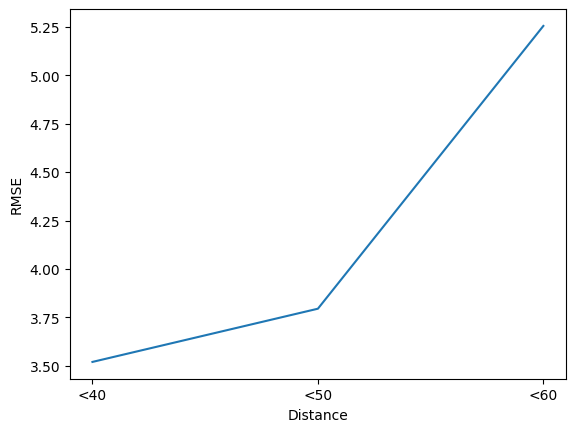

In [78]:
plt.plot(["<40", "<50", "<60"], [loss1.item(), loss2.item(), loss3.item()])
plt.xlabel("Distance")
plt.ylabel("RMSE")

In [83]:
res = {}

In [86]:

for ckpt_path in [ckpt_pth_distance, ckpt_pth_angle, ckpt_pth_multitask]:
    task = "angle" if 'angle' in ckpt_path else "distance" if "distance" in ckpt_path else "multitask"
    multitask = task == 'multitask'
    model = VTN(multitask=task, backbone=backbone)
    module = LaneModule(model, multitask=task, dataset = dataset, bs=bs)
    pth = f"/data1/jessica/data/toyota/ckpts/COMMA/checkpoints_{dataset}_{task}"
    logger = TensorBoardLogger(save_dir=pth)
    trainer = pl.Trainer(
        accelerator="gpu",
        devices=[gpu_num] if torch.cuda.is_available() else None, 
        logger=logger,
        max_epochs=100,
        default_root_dir=pth
        )
    preds = trainer.predict(module, ckpt_path=ckpt_path)
    rmses = []
    for i in range(len(preds)):
        elem = preds[i]
        if multitask:
            logits_angle, logits_distance = elem[0][0], elem[0][1]
        logits, angle, distance = elem[0], elem[1].squeeze(), elem[2].squeeze()
        if "multitask" in ckpt_path:
            loss = calculate_loss(logits, angle, distance, multitask='multitask')  
            rmses.append(loss)
        if "angle" in ckpt_path:
            loss = calculate_loss(logits, angle, distance, multitask="angle") 
            rmses.append(loss.item())
        if "distance" in ckpt_path:
            distance = angle
            loss = calculate_loss(logits, distance, distance, multitask="distance")
            rmses.append(loss.item())
        
    res[task] = rmses
    print(rmses)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at /data1/jessica/data/toyota/ckpts/COMMA/checkpoints_comma_distance/lightning_logs/version_40/checkpoints/epoch=39-step=1960.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from checkpoint at /data1/jessica/data/toyota/ckpts/COMMA/checkpoints_comma_distance/lightning_logs/version_40/checkpoints/epoch=39-step=1960.ckpt


Predicting DataLoader 0: 100%|██████████| 17/17 [00:06<00:00,  2.47it/s]
[2.5980257987976074, 1.3191032409667969, 7.127370834350586, 4.841986656188965, 3.6089580059051514, 6.455803871154785, 1.985696792602539, 3.1754720211029053, 2.6144444942474365, 2.7192697525024414, 8.156237602233887, 9.532102584838867, 1.4478585720062256, 3.6989197731018066, 10.153376579284668, 5.490836143493652, 7.1447601318359375]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at /data1/jessica/data/toyota/ckpts/COMMA/checkpoints_comma_angle/lightning_logs/version_17/checkpoints/epoch=21-step=1694.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from checkpoint at /data1/jessica/data/toyota/ckpts/COMMA/checkpoints_comma_angle/lightning_logs/version_17/checkpoints/epoch=21-step=1694.ckpt


Predicting DataLoader 0: 100%|██████████| 17/17 [00:06<00:00,  2.62it/s]
[0.6844321489334106, 0.9177812337875366, 1.014853596687317, 1.1459578275680542, 0.950522780418396, 1.2839751243591309, 1.2589852809906006, 1.2417669296264648, 1.4209685325622559, 23.016117095947266, 1.0574407577514648, 0.8290581107139587, 2.9135537147521973, 1.1342591047286987, 1.0155333280563354, 0.9546523690223694, 0.9258266091346741]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at /data1/jessica/data/toyota/ckpts/COMMA/checkpoints_comma_multitask/lightning_logs/version_23/checkpoints/epoch=31-step=2464.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from checkpoint at /data1/jessica/data/toyota/ckpts/COMMA/checkpoints_comma_multitask/lightning_logs/version_23/checkpoints/epoch=31-step=2464.ckpt


Predicting DataLoader 0: 100%|██████████| 17/17 [00:07<00:00,  2.38it/s]
[(tensor(0.5013), tensor(9.0443)), (tensor(0.7587), tensor(6.6789)), (tensor(1.1444), tensor(8.3457)), (tensor(1.0015), tensor(4.9579)), (tensor(1.1306), tensor(10.2125)), (tensor(1.4232), tensor(8.5848)), (tensor(1.0514), tensor(12.4867)), (tensor(1.4981), tensor(8.2965)), (tensor(0.9381), tensor(1.7110)), (tensor(22.4403), tensor(4.2770)), (tensor(0.8648), tensor(9.4183)), (tensor(0.9312), tensor(7.2483)), (tensor(1.5865), tensor(2.7828)), (tensor(1.0962), tensor(6.6330)), (tensor(1.0980), tensor(8.1372)), (tensor(0.8705), tensor(12.3708)), (tensor(1.0050), tensor(8.6351))]


In [111]:
df = pd.DataFrame()
df['distance'] = res['distance']
df['angle'] = res['angle']
df['driver'] = range(len(res['angle']))
alt.Chart(df).mark_circle(size=60).encode(
    x='distance',
    y='angle',
    tooltip=['driver']
).interactive()


alt.Chart(...)

In [114]:
l = list(zip(*res["multitask"]))
z = l[1]
y = l[0]
df = pd.DataFrame()
df['distance'] = z
df['distance'] = df['distance'].apply(lambda x: x.item())
df['angle'] = y
df['angle'] = df['angle'].apply(lambda x: x.item())
df['driver'] = range(len(y))
alt.Chart(df).mark_circle(size=60).encode(
    x='distance',
    y='angle',
    tooltip=['driver']
).interactive()

(tensor(9.0443), tensor(6.6789), tensor(8.3457), tensor(4.9579), tensor(10.2125), tensor(8.5848), tensor(12.4867), tensor(8.2965), tensor(1.7110), tensor(4.2770), tensor(9.4183), tensor(7.2483), tensor(2.7828), tensor(6.6330), tensor(8.1372), tensor(12.3708), tensor(8.6351)) (tensor(0.5013), tensor(0.7587), tensor(1.1444), tensor(1.0015), tensor(1.1306), tensor(1.4232), tensor(1.0514), tensor(1.4981), tensor(0.9381), tensor(22.4403), tensor(0.8648), tensor(0.9312), tensor(1.5865), tensor(1.0962), tensor(1.0980), tensor(0.8705), tensor(1.0050))


alt.Chart(...)

In [ ]:
preds_path = '/data1/jessica/data/toyota/ckpts/COMMA/checkpoints_comma_distance/lightning_logs/version_49/dist.csv'
df = pd.read_csv(preds_path)
df.columns = ['preds', 'targets']
df = df[df['targets'] != 0]
df['err'] = df['targets'] - df['preds']
ten = df[df['targets'] < 10]
six = df[df['targets'] > 60]
twen = df[(df['targets'] > 10 & (df['targets'] < 20))]
four = df[(df['targets'] > 20 & (df['targets'] < 40))]
fift = df[(df['targets'] > 40 & (df['targets'] < 60))]
ndf = {}
ndf["<10"] = ten['err'].tolist()
ndf["10-20"] = twen['err'].tolist()
ndf["20-40"] = four['err'].tolist()
ndf["40-60"] = fift['err'].tolist()
ndf[">60"] = six['err'].tolist()
my_dict = ndf

fig, ax = plt.subplots()
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())